# TEMPO pour ChatGPT

In [6]:
import xarray as xr
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

eddies_train = xr.open_dataset("data/eddies_train.nc")
OSSE_train = xr.open_dataset("data/OSSE_U_V_SLA_SST_train.nc")

# Remplacer les valeurs de "nan", "NaN", "NAN" par np.nan
eddies_train["eddies"] = eddies_train["eddies"].where(~eddies_train["eddies"].isin(["nan", "NaN", "NAN", "NaN "]), np.nan)

# Vérifier le nombre de NaN avant modification
print("Nombre de NaN avant :", np.isnan(eddies_train["eddies"]).sum().values)

# Remplacer les NaN par 999
eddies_train["eddies"] = eddies_train["eddies"].fillna(999)

# Vérifier qu'il n'y a plus de NaN
print("Nombre de NaN après :", np.isnan(eddies_train["eddies"]).sum().values)

# Vérifier et remplacer les occurrences de "nan", "NaN", "NAN", "NaN " par np.nan dans chaque variable
for var in OSSE_train.data_vars:
    # Remplacer les valeurs de "nan", "NaN", "NAN", "NaN " par np.nan
    OSSE_train[var] = OSSE_train[var].where(~OSSE_train[var].isin(["nan", "NaN", "NAN", "NaN "]), np.nan)
    
    # Vérifier le nombre de NaN dans chaque variable avant modification
    print(f"Nombre de NaN dans {var} avant :", np.isnan(OSSE_train[var]).sum().values)

# Remplacer les NaN par 999 pour chaque variable
for var in OSSE_train.data_vars:
    OSSE_train[var] = OSSE_train[var].fillna(0)

# Vérifier qu'il n'y a plus de NaN
for var in OSSE_train.data_vars:
    print(f"Nombre de NaN dans {var} après :", np.isnan(OSSE_train[var]).sum().values)

# Renommer `time_counter` en `time`
OSSE_train = OSSE_train.rename({"time_counter": "time"})

# Supprimer l'ancienne dimension `time_counter` si elle est encore présente
if "time_counter" in OSSE_train.coords:
    OSSE_train = OSSE_train.drop_vars("time_counter")

# Fusionner les datasets
merged_ds = xr.merge([eddies_train, OSSE_train])
merged_ds

# Remplacer les occurrences de chaînes 'nan', 'NaN', 'NAN' par np.nan
merged_ds = merged_ds.apply(lambda x: x.where(~x.isin(['nan', 'NaN', 'NAN']), np.nan))

# Remplacer toutes les occurrences de NaN (y compris celles qui sont des np.nan maintenant) par 0
merged_ds = merged_ds.fillna(0)

# Vérifier le nombre de NaN dans chaque variable après modification
for var in merged_ds.data_vars:
    print(f"Nombre de NaN dans {var} après remplacement :", np.isnan(merged_ds[var]).sum().values)
    
from sklearn.preprocessing import MinMaxScaler

vars_to_normalize = ["vomecrtyT", "vozocrtxT", "sossheig", "votemper"]

def min_max_scale(da):
    scaler = MinMaxScaler()
    flat_data = da.values.reshape(-1, 1)
    scaled = scaler.fit_transform(flat_data).reshape(da.shape)
    return xr.DataArray(scaled, coords=da.coords, dims=da.dims, attrs=da.attrs)

normalized_ds = merged_ds.copy()
for var in vars_to_normalize:
    normalized_ds[var] = min_max_scale(merged_ds[var])


print(normalized_ds)

Nombre de NaN avant : 23685032
Nombre de NaN après : 0
Nombre de NaN dans vomecrtyT avant : 24555776
Nombre de NaN dans vozocrtxT avant : 24555776
Nombre de NaN dans sossheig avant : 23685032
Nombre de NaN dans votemper avant : 23685032
Nombre de NaN dans vomecrtyT après : 0
Nombre de NaN dans vozocrtxT après : 0
Nombre de NaN dans sossheig après : 0
Nombre de NaN dans votemper après : 0
Nombre de NaN dans eddies après remplacement : 0
Nombre de NaN dans vomecrtyT après remplacement : 0
Nombre de NaN dans vozocrtxT après remplacement : 0
Nombre de NaN dans sossheig après remplacement : 0
Nombre de NaN dans votemper après remplacement : 0
<xarray.Dataset> Size: 2GB
Dimensions:    (time: 284, latitude: 357, longitude: 717)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2015-01-02T12:00:00 ... 2015-12-25T1...
  * latitude   (latitude) float32 1kB -1.084e-19 2.967 0.0 ... 3.099 0.0
  * longitude  (longitude) float32 3kB 3.689e+19 -3.352 0.0 ... -3.221 0.0
    deptht     float32 4B 0

## Partie initiale juste

In [ ]:
import torch
import xarray as xr
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

ds = normalized_ds

# Définition de la classe OsseDataset
class OsseDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (xarray.Dataset): Doit contenir les variables 
                vozocrtxT, vomecrtyT, sossheig, votemper, eddies.
            transform (callable, optional): Transformation à appliquer.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return self.data.dims["time"]

    def __getitem__(self, idx):
        # Extraction des variables (chaque variable est de forme (H, W))
        U = self.data.vozocrtxT.values[idx, :, :]
        V = self.data.vomecrtyT.values[idx, :, :]
        sossheig = self.data.sossheig.values[idx, :, :]
        votemper = self.data.votemper.values[idx, :, :]
        eddies = self.data.eddies.values[idx, :, :]

        # Conversion en tenseurs PyTorch
        U = torch.tensor(U, dtype=torch.float32)
        V = torch.tensor(V, dtype=torch.float32)
        sossheig = torch.tensor(sossheig, dtype=torch.float32)
        votemper = torch.tensor(votemper, dtype=torch.float32)
        targets = torch.tensor(eddies, dtype=torch.float32)
        
        # Concaténation des tenseurs le long de la dimension des canaux
        inputs_tensor = torch.stack([U, V, sossheig, votemper], dim=0)
        
        # Appliquer une transformation si nécessaire
        if self.transform:
            sample = {'inputs': inputs_tensor, 'targets': targets}
            sample = self.transform(sample)
            return sample['inputs'], sample['targets']

        return inputs_tensor, targets

# Création de l'instance du dataset
dataset = OsseDataset(ds, transform=None)

# Division en ensembles d'entraînement et de validation (80%/20%)
total_samples = len(dataset)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

b_size = 8

# Création des DataLoader pour l'entraînement et la validation
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=b_size, shuffle=False)


class EddyPredictorCNN(nn.Module):
    def __init__(self):
        super(EddyPredictorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=1)  # Renvoie une carte de sortie d'un canal
        )

    def forward(self, x):
        return self.conv_layers(x)


# Utilisation de MSELoss pour la régression (remplaçant de CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(ignore_index=999)

def validation(net):
    net.eval()
    valid_loss = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            labels = labels.long()
            inputs_tensor = inputs.to(device)
            labels = labels.to(device)
            #labels = labels.unsqueeze(1).to(device)  # Ajoute la dimension des canaux
            #print(labels.shape)
            # Prédictions et calcul de la perte
            outputs = net(inputs_tensor)
            #print(outputs)
            #print(outputs.shape)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

    valid_loss /= len(val_loader)  # Moyenne des pertes
    net.train()
    return valid_loss

def train(model, num_epochs, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_history = []
    valid_history = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            targets = targets.long()
            inputs_tensor = inputs.to(device)
            targets = targets.to(device)  # Envoi sur GPU           
            
            optimizer.zero_grad()
            outputs = model(inputs_tensor)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)  # Moyenne de la perte sur chaque image
        valid_loss = validation(model)  # Calcul validation loss
        train_history.append(train_loss) # On ajoute tout aux listes pour tracer les résultats 
        valid_history.append(valid_loss)
        
        print(f'Epoch {epoch:02d}: train loss {train_loss:.5f}, validation loss {valid_loss:.5f}')
    
    torch.save(model.state_dict(), "eddy_predictor.pth")

    return train_history, valid_history
    
from matplotlib import pyplot as plt 
import numpy as np
from sklearn.metrics import accuracy_score

def plot_train_val(train, valid):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_ylabel('Training', color=color)
    ax1.plot(train, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation', color=color)
    plt.title('Loss')
    ax2.plot(valid, color=color)
    fig.tight_layout()

def get_valid_predictions(net, loader, device):
    net.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)  # shape: (batch, H, W)
            outputs = net(inputs)      # shape: (batch, 3, H, W)
            # Obtenir la classe prédite pour chaque pixel
            _, preds = torch.max(outputs, 1)  # preds: (batch, H, W)

            # Convertir en numpy
            labels_np = labels.cpu().numpy()
            preds_np = preds.cpu().numpy()
            
            # Appliquer le masque pour ignorer les pixels dont le label est 999
            mask = labels_np != 999
            # Garder seulement les pixels où mask est True
            valid_labels = labels_np[mask]
            valid_preds = preds_np[mask]
            
            all_labels.append(valid_labels)
            all_preds.append(valid_preds)
    
    # Concaténer les résultats pour obtenir un tableau 1D
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    return all_labels, all_preds

# On se met sur les GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Device utilisé :", device)

 
# Initialisation du modèle
model = EddyPredictorCNN()
model = model.to(device) # Ajoutez les parenthèses pour instancier le modèle

train_history, valid_history = train(model, 15, device)



/var/folders/m3/k2rlmgps1yg0xlxmdh61l9pw0000gn/T/ipykernel_93814/3223464861.py:22: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.data.dims["time"]


Device utilisé : mps
Epoch 00: train loss 0.94684, validation loss 0.79238
Epoch 01: train loss 0.74722, validation loss 0.73651
Epoch 02: train loss 0.72425, validation loss 0.71653
Epoch 03: train loss 0.70696, validation loss 0.70212
Epoch 04: train loss 0.69516, validation loss 0.69290
Epoch 05: train loss 0.68946, validation loss 0.68780
Epoch 06: train loss 0.68558, validation loss 0.68485
Epoch 07: train loss 0.68360, validation loss 0.68267
Epoch 08: train loss 0.68192, validation loss 0.68120
Epoch 09: train loss 0.68045, validation loss 0.67981
Epoch 10: train loss 0.67877, validation loss 0.67857
Epoch 11: train loss 0.67776, validation loss 0.67767
Epoch 12: train loss 0.67747, validation loss 0.67638
Epoch 13: train loss 0.67618, validation loss 0.67551
Epoch 14: train loss 0.67510, validation loss 0.67469


Accuracy (ignoring 999): 0.7694200007380638


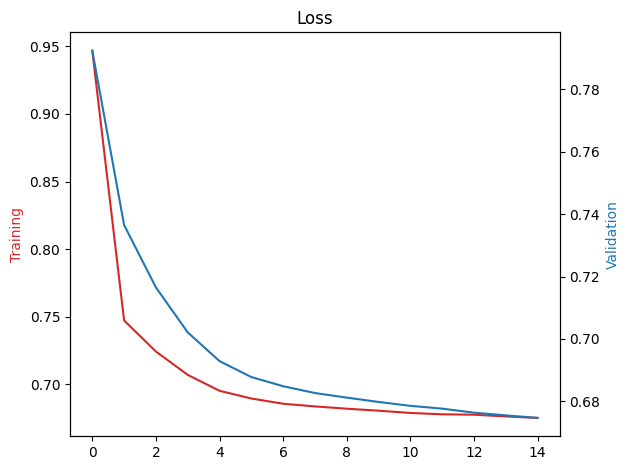

In [57]:
all_labels, all_preds = get_valid_predictions(model, val_loader, device)
acc = accuracy_score(all_labels, all_preds)
print("Accuracy (ignoring 999):", acc)
plot_train_val(train_history, valid_history)

In [ ]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(4, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.center = self.conv_block(512, 1024)
        self.dec4 = self.conv_block(1024 + 512, 512)
        self.dec3 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        center = self.center(F.max_pool2d(enc4, 2))
        
        # Spécifier la taille exacte pour l'interpolation
        up_center = F.interpolate(center, size=enc4.shape[-2:], mode='bilinear', align_corners=True)
        dec4 = self.dec4(torch.cat([up_center, enc4], dim=1))
        
        up_dec4 = F.interpolate(dec4, size=enc3.shape[-2:], mode='bilinear', align_corners=True)
        dec3 = self.dec3(torch.cat([up_dec4, enc3], dim=1))
        
        up_dec3 = F.interpolate(dec3, size=enc2.shape[-2:], mode='bilinear', align_corners=True)
        dec2 = self.dec2(torch.cat([up_dec3, enc2], dim=1))
        
        up_dec2 = F.interpolate(dec2, size=enc1.shape[-2:], mode='bilinear', align_corners=True)
        dec1 = self.dec1(torch.cat([up_dec2, enc1], dim=1))
        
        final = self.final(dec1)
        return final

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        # Encodeur simplifié
        self.enc1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(3)
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Décodeur simplifié
        self.up = nn.Upsample(scale_factor=3, mode='bilinear', align_corners=True)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Couche finale pour la classification (3 classes)
        self.final = nn.Conv2d(16, 3, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.enc1(x)             # (batch, 16, H, W)
        pooled = self.pool(enc1)        # (batch, 16, H/2, W/2)
        bottleneck = self.bottleneck(pooled)  # (batch, 32, H/2, W/2)
        upsampled = self.up(bottleneck) # (batch, 32, H, W)
        dec1 = self.dec1(upsampled)     # (batch, 16, H, W)
        final = self.final(dec1)        # (batch, 3, H, W)
        
        # Redimensionner la sortie à (357, 717) exactement,
        # quelle que soit la taille actuelle.
        final = F.interpolate(final, size=(357, 717), mode='bilinear', align_corners=True)
        return final

# On se met sur les GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Device utilisé :", device)

 
# Initialisation du modèle
model2 = SimpleUNet()
model2 = model2.to(device) # Ajoutez les parenthèses pour instancier le modèle

train_history2, valid_history2 = train(model2, 5, device)

Device utilisé : mps
Epoch 00: train loss 0.82387, validation loss 0.70833
Epoch 01: train loss 0.68612, validation loss 0.67688
Epoch 02: train loss 0.67437, validation loss 0.67146
Epoch 03: train loss 0.67075, validation loss 0.66877
Epoch 04: train loss 0.66876, validation loss 0.66579


Accuracy (ignoring 999): 0.7694200007380638


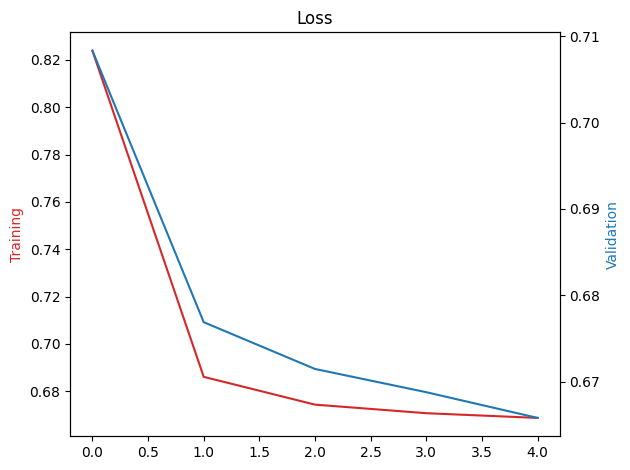

In [71]:
all_labels2, all_preds2 = get_valid_predictions(model2, val_loader, device)
acc2 = accuracy_score(all_labels2, all_preds2)
print("Accuracy (ignoring 999):", acc2)
plot_train_val(train_history2, valid_history2)